# Foraging - Independent Q-Learning

## Pre-requisites

### Imports

In [1]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from games.foraging import Foraging 
from agents.independent_q_learning import IQL

In [2]:
# Make plots smaller
plt.rcParams['figure.figsize'] = (8, 4)


In [3]:
game = Foraging(config="Foraging-8x8-2p-2f-v3", seed=42)
game.reset()

#print game information
rewards = game.rewards
observations = game.observations
terminations = game.terminations
truncations = game.truncations
infos = game.infos
print("Game Information:")
print("Rewards: ", rewards)
print("Observations: ", observations)
print("Terminations: ", terminations)

print("Truncations: ", truncations)
print("Infos: ", infos)

Game Information:
Rewards:  {'agent_0': 0, 'agent_1': 0}
Observations:  {'agent_0': array([2., 1., 2., 5., 5., 2., 6., 5., 1., 3., 6., 1.], dtype=float32), 'agent_1': array([2., 1., 2., 5., 5., 2., 3., 6., 1., 6., 5., 1.], dtype=float32)}
Terminations:  {'agent_0': False, 'agent_1': False}
Truncations:  {'agent_0': False, 'agent_1': False}
Infos:  {'agent_0': {}, 'agent_1': {}}


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


### Epsilon and Alpha function that will be used in the Q-learning algorithm

Text(0.5, 1.0, 'Epsilon Function Decay')

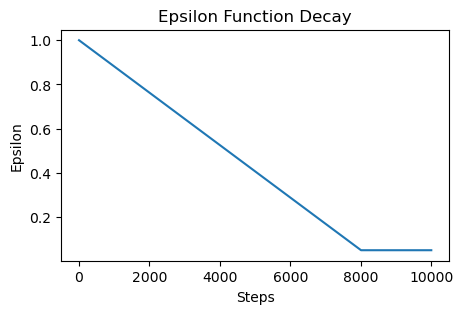

In [4]:
def epsilon_func(i: int, min_value=0.05, max_value=1.0, decay_steps=8000):
        """
        Epsilon decay should linearly decay from max_value to min_value in the first decay_steps,
        and then stay at min_value for the rest of the training.
        """
        if i < decay_steps:
            # Linearly decay epsilon
            return max_value - (max_value - min_value) * (i / decay_steps)
        else:
            # Keep epsilon at min_value after decay_steps
            return min_value
        
def get_epsilon_func(min_value=0.05, max_value=1.0, decay_steps=8000):
    """
    Returns the epsilon function with the specified parameters.
    """
    return partial(epsilon_func, min_value=min_value, max_value=max_value, decay_steps=decay_steps)

values = []
for i in range(0, 10000):
    epsilon = epsilon_func(i)
    values.append(epsilon)

plt.figure(figsize=(5, 3))
plt.plot(values)
plt.xlabel('Steps')
plt.ylabel('Epsilon')
plt.title('Epsilon Function Decay')

In [5]:
# Alpha is just 0.1 for all steps
def alpha_func(i: int, value=0.1):
        return 0.1

def get_alpha_func(value =0.1):
    """
    Returns the alpha function with the specified parameters.
    """
    return partial(alpha_func, value=value)

### Utility functions

In [6]:
def run(game, agents, verbose=False, render=False, training=True):
    game.reset()
    cum_rewards = dict(map(lambda agent: (agent, 0), game.agents))

    if render:
        game.render()
        time.sleep(3) # Wait for 2 seconds before starting the game

    while not game.done():
        actions = dict(map(lambda agent: (agent, agents[agent].action()), game.agents))
        game.step(actions)

        for agent in game.agents:
            if training:
                # Update the agent only if training is enabled
                agents[agent].update()
            cum_rewards[agent] += game.reward(agent)

        if verbose:
            for agent in game.agents:
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.15)
        
    return cum_rewards

In [7]:
def train(game, agents, iterations, episodes_per_iteration, verbose=False):
    reward_list = {agent: [] for agent in game.agents}
    rewards_per_iteration = {agent: [] for agent in game.agents}
    for i in range(iterations):
        for j in range(episodes_per_iteration):
            cum_rewards = run(game, agents, verbose=False, render=False, training=True)
            for agent in game.agents:
                reward_list[agent].append(cum_rewards[agent])

        for agent in game.agents:
            rewards_per_iteration[agent].append(np.mean(reward_list[agent][-episodes_per_iteration:]))
        if verbose:
            # Print the average rewards for each agent after each iteration
            print(f"Iteration {i+1}, Total Episodes {(j+1)* (i+1)}")
            for agent in game.agents:
                print(f"Agent {agent}, Average reward: {rewards_per_iteration[agent][i]}")
    
    # return the average rewards for each agent after training
    return rewards_per_iteration

def plot_rewards(rewards, config):
    plt.figure(figsize=(10, 5))
    for agent in rewards:
        plt.plot(rewards[agent], label=f"Agent {agent}")
    plt.title(f"Rewards for Configuration {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
def plot_rewards_on_multiple_runs(all_rewards, config):
    # Convert to 3D array: runs x agents x iterations
    all_rewards = np.array(all_rewards)

    # Compute mean and std across runs, for each agent and iteration
    mean_rewards = np.mean(all_rewards, axis=0)  # shape: agents x iterations
    std_rewards = np.std(all_rewards, axis=0)    # shape: agents x iterations

    # Plot mean and std for each agent
    iterations = np.arange(mean_rewards.shape[1])
    for agent_idx, agent in enumerate(game.agents):
        plt.plot(iterations, mean_rewards[agent_idx], label=f"Agent {agent} Mean")
        plt.fill_between(iterations, 
                        mean_rewards[agent_idx] - std_rewards[agent_idx], 
                        mean_rewards[agent_idx] + std_rewards[agent_idx], 
                        alpha=0.2, label=f"Agent {agent} Std")

    plt.title(f"Mean and Std Rewards over {config['num_runs']} Runs for {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.legend()
    plt.grid()
    plt.show()

def plot_sum_all_rewards(all_rewards, config):
    # all_rewards shape: (num_runs, num_agents, num_iterations)
    # Compute sum of rewards across agents for each run and iteration
    sum_rewards_per_run = np.sum(all_rewards, axis=1)  # shape: (num_runs, num_iterations)

    # Compute mean and std across runs, for each iteration
    mean_sum_rewards = np.mean(sum_rewards_per_run, axis=0)  # shape: (num_iterations,)
    std_sum_rewards = np.std(sum_rewards_per_run, axis=0)    # shape: (num_iterations,)

    # Plot mean and std of sum of rewards
    iterations = np.arange(mean_sum_rewards.shape[0])
    plt.plot(iterations, mean_sum_rewards, label="Mean Sum of Rewards")
    plt.fill_between(iterations, 
                    mean_sum_rewards - std_sum_rewards, 
                    mean_sum_rewards + std_sum_rewards, 
                    alpha=0.2, label="Std Dev")
    plt.axhline(y=1, color='r', linestyle='--', label="Target")
    plt.title(f"Mean and Std of Sum of Rewards over {config['num_runs']} Runs for {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Sum of Rewards")
    plt.legend()
    plt.grid()
    plt.show()

## 5x5 - 2 Players - 2 Food

<img src="./attachments/5x5-2p-2f.png" width="200"/>

In [ ]:
config = {
        "game": "Foraging-5x5-2p-2f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


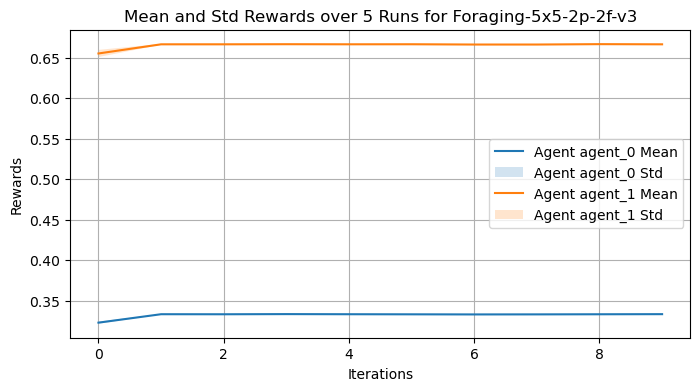

In [25]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)


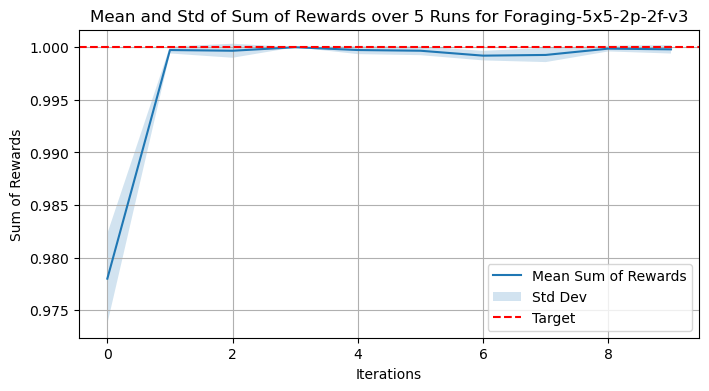

In [26]:
plot_sum_all_rewards(all_rewards, config)

In [14]:
# Run a single episode on the last trained agents
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## 8x8 - 2 Players - 2 Food

<img src="./attachments/8x8-2p-2f.png" width="300"/>

In [ ]:
config = {
        "game": "Foraging-8x8-2p-2f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Run 2/5
Run 3/5
Run 4/5
Run 5/5


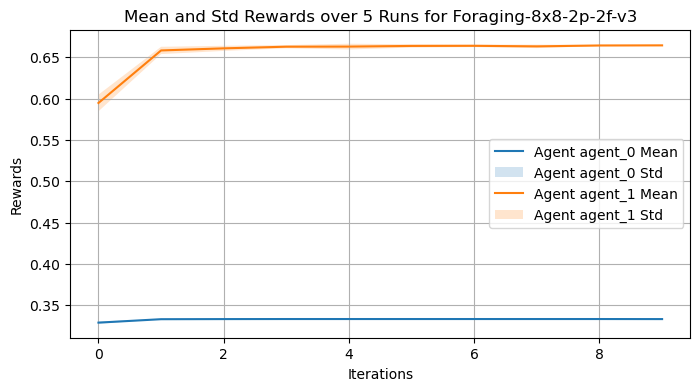

In [30]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

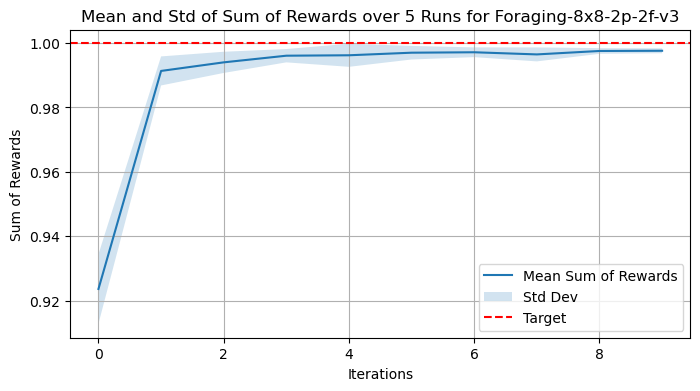

In [31]:
plot_sum_all_rewards(all_rewards, config)

In [32]:
# Run the agents with render to see how they behave in the environment.
# run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## 8x8 - 2 Players - 3 Food

<img src="./attachments/8x8-2p-3f.png" width="300"/>

In [ ]:
config = {
        "game": "Foraging-8x8-2p-3f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9
        },
        "train": {
            "iterations": 30, # This environment requires more iterations to converge
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Run 2/5
Run 3/5
Run 4/5
Run 5/5


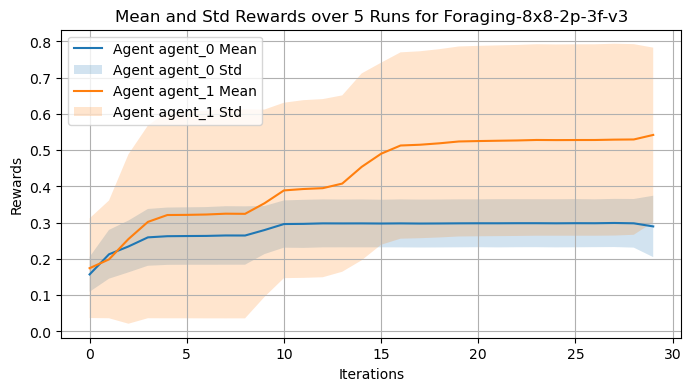

In [39]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

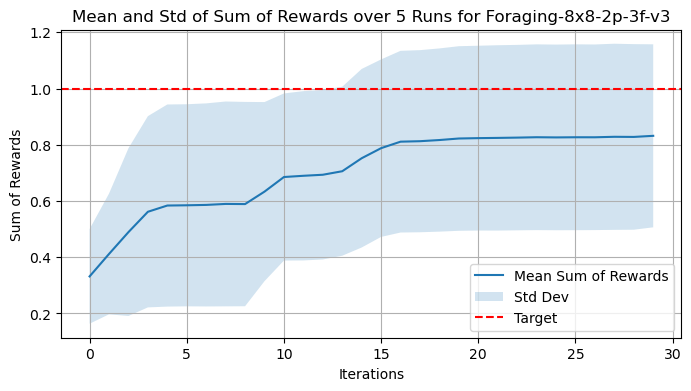

In [41]:
plot_sum_all_rewards(all_rewards, config)

**Interesting behaviour observed:** In this environment, the players need to do a lot of steps, and because the maximum reward diminishes by the amount of steps, it is impossible for the agents to get reward 1.0.

In [46]:
# Run the agents with render to see how they behave in the environment.
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 1. 1. 1. 1. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 1. 6. 2. 1. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 2. 1. 1. 1. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 1. 6. 2. 2. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 3. 1. 1. 0. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 6. 2. 3. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 3. 1. 1. 0. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 6. 2. 3. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 3. 2. 1. 0. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 6. 2. 3. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 

{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## 8x8 - 3 Players - 1 Food

Aumentamos la cantidad de agentes para ver como se comportan en un ambiente más complejo.

<img src="./attachments/8x8-3p-1f.png" width="300"/>

In [65]:
config = {
        "game": "Foraging-8x8-3p-1f-v3",
        "seed": 1,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


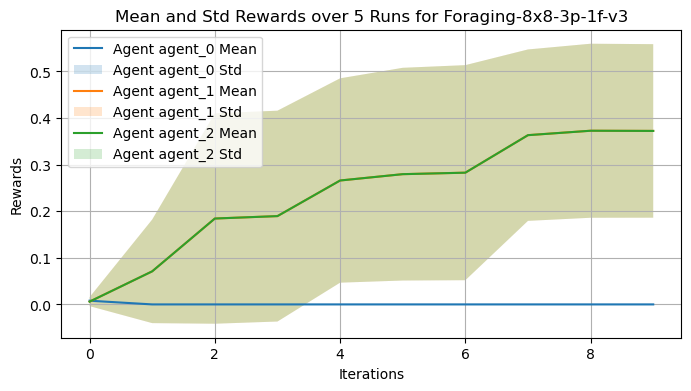

In [66]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

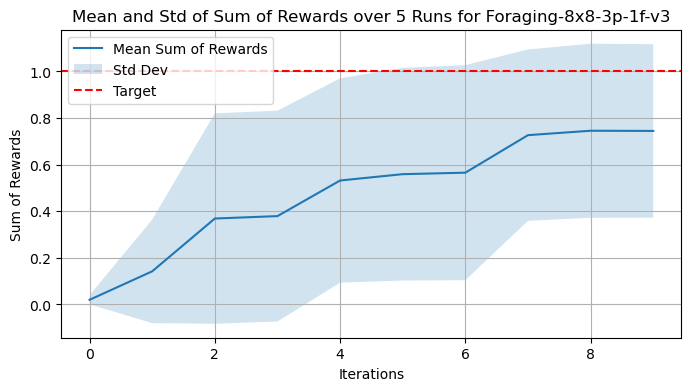

In [67]:
plot_sum_all_rewards(all_rewards, config)

In [68]:
# Run the agents with render to see how they behave in the environment.
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0, 'agent_1': 0.5, 'agent_2': 0.5}

## 8x8 - 3 Players - 2 Food

Esta configuración ya es tan compleja que requiere una cantidad mucho mayor de iteraciones para converger. Tambien actualizamos nuestra funcion de epsilon para que decrezca más lento teniendo en cuenta la mayor cantidad de steps.

<img src="./attachments/8x8-3p-2f.png" width="300"/>

In [76]:
config = {
        "game": "Foraging-8x8-3p-2f-v3",	
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(value=0.01),
            "epsilon": get_epsilon_func(decay_steps=100000), # Cambiamos decay_steps de 8000 a 100000
            "gamma": 0.9,
        },
        "train": {
            "iterations": 400, # Utilizamos 400 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 400.000 episodios.
    }

Run 1/5


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Run 2/5
Run 3/5
Run 4/5
Run 5/5


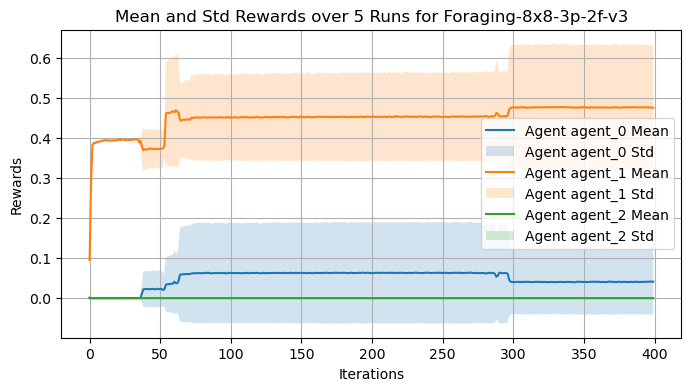

In [73]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

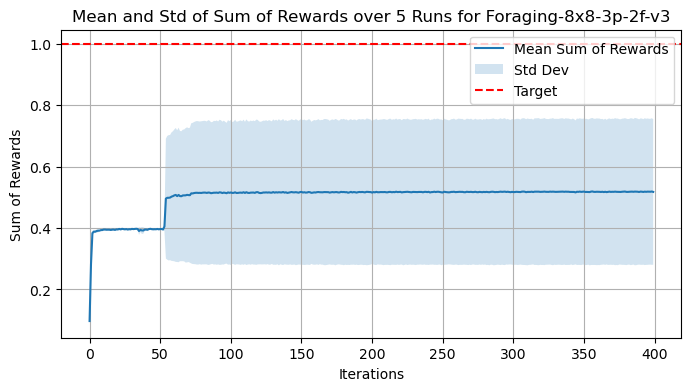

In [74]:
plot_sum_all_rewards(all_rewards, config)

In [75]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0, 'agent_1': 0.4, 'agent_2': 0}

### 8x8 - 3 Players - 2 Food - Retrain 100k

Training agents in Foraging-8x8-3p-2f-v3, iterations: 100, episodes per iteration: 1000


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.00013333333333333334
Agent agent_1, Average reward: 0.15346666666666667
Agent agent_2, Average reward: 0.0
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.36160000000000003
Agent agent_2, Average reward: 0.0
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3748000000000001
Agent agent_2, Average reward: 0.0
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.37160000000000004
Agent agent_2, Average reward: 0.0
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.37360000000000004
Agent agent_2, Average reward: 0.0
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.37760000000000005
Agent agent_2, Average reward: 0.0
Iteration 7, Total Episodes 7000
Agent agent_0, Average re

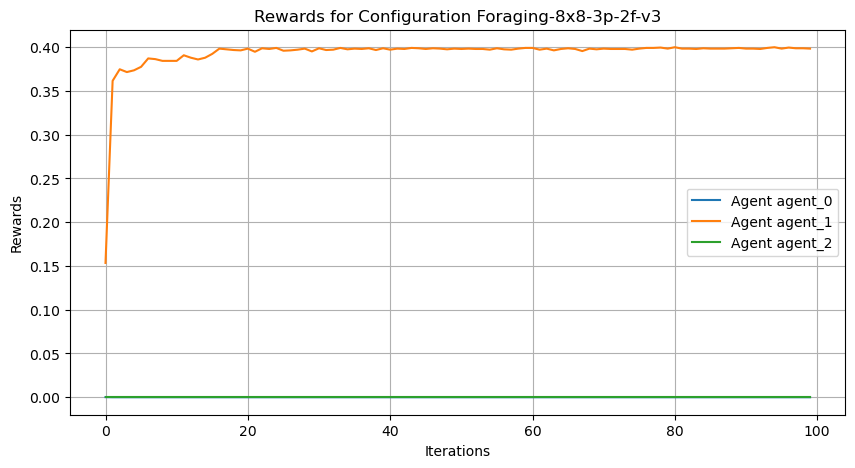

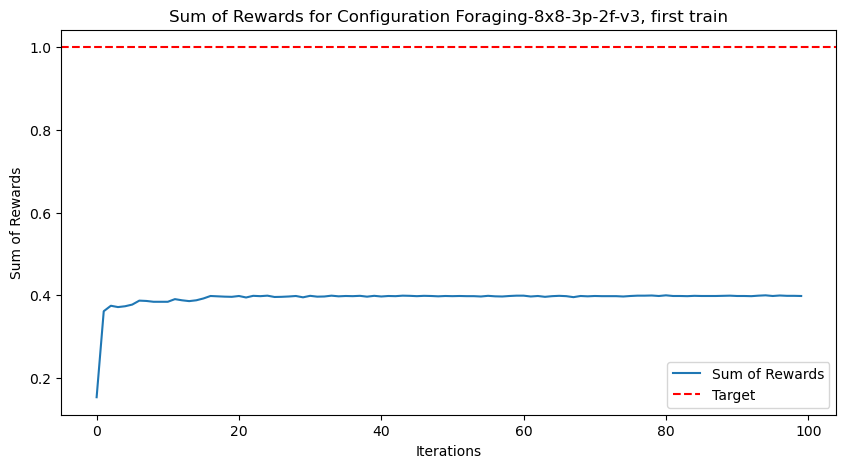

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3984000000000001
Agent agent_2, Average reward: 0.0
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.4000000000000001
Agent agent_2, Average reward: 0.0
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3980000000000001
Agent agent_2, Average reward: 0.0
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39920000000000005
Agent agent_2, Average reward: 0.0
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39880000000000004
Agent agent_2, Average reward: 0.0
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39880000000000004
Agent agent_2, Average reward: 0.0
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.0
Agent agent

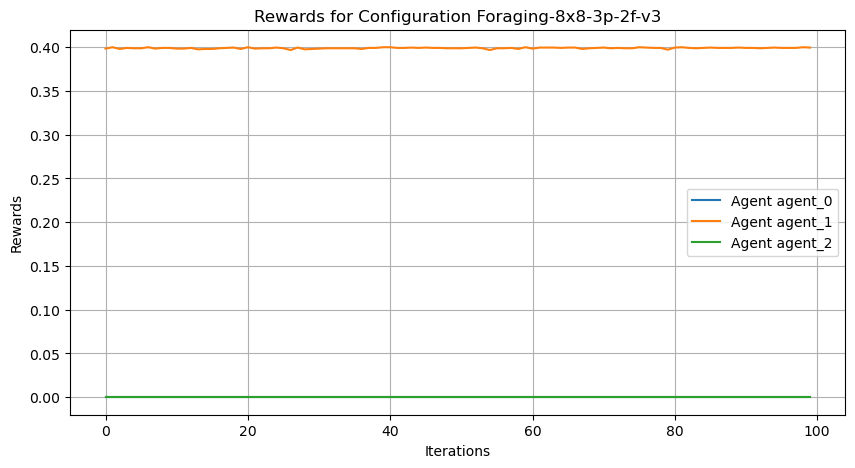

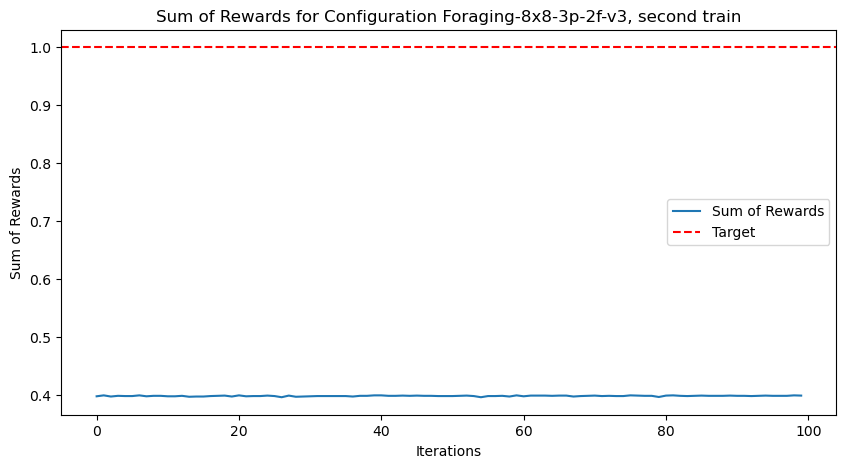

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39920000000000005
Agent agent_2, Average reward: 0.0
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.4000000000000001
Agent agent_2, Average reward: 0.0
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39960000000000007
Agent agent_2, Average reward: 0.0
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39960000000000007
Agent agent_2, Average reward: 0.0
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39880000000000004
Agent agent_2, Average reward: 0.0
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39880000000000004
Agent agent_2, Average reward: 0.0
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.0
Agent age

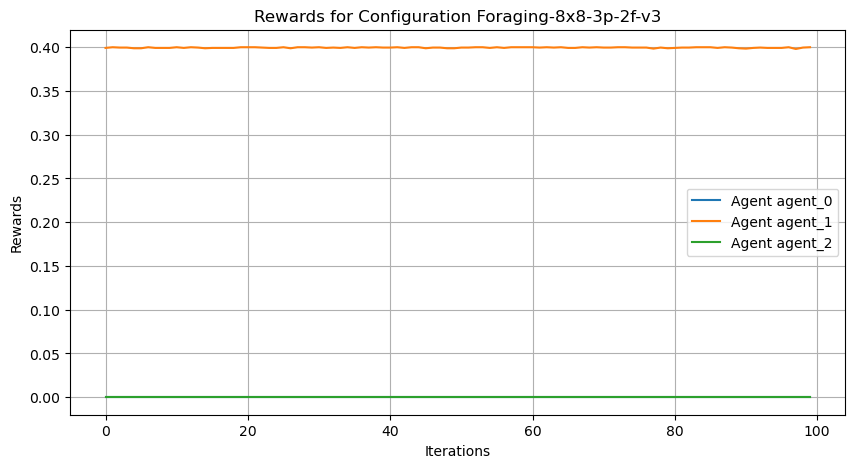

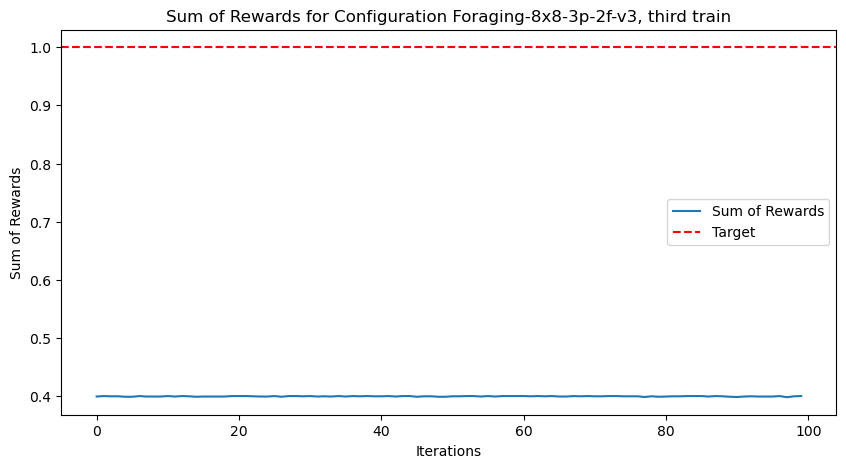

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39920000000000005
Agent agent_2, Average reward: 0.0
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3996
Agent agent_2, Average reward: 0.0
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3996
Agent agent_2, Average reward: 0.0
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.3996
Agent agent_2, Average reward: 0.0
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.39880000000000004
Agent agent_2, Average reward: 0.0
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.4000000000000001
Agent agent_2, Average reward: 0.0
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.400000000000000

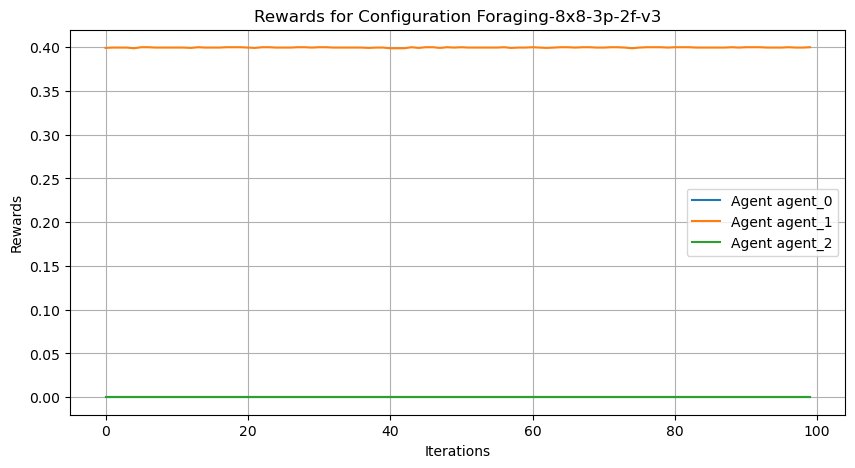

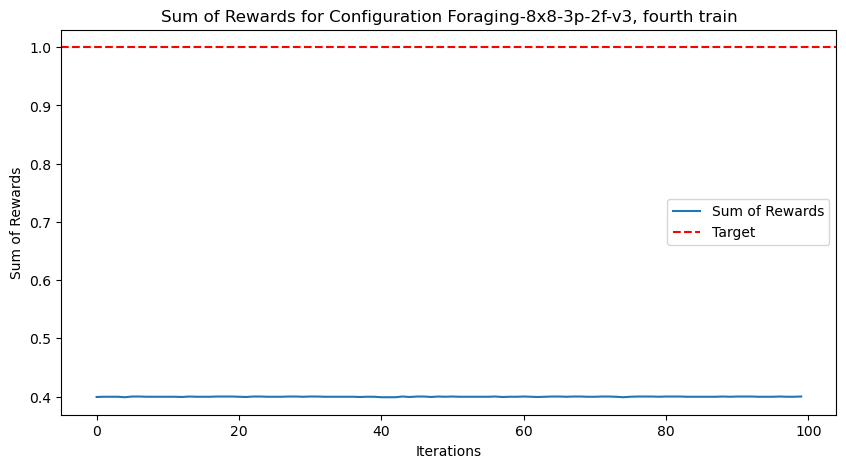

In [19]:
config = {
        "game": "Foraging-8x8-3p-2f-v3",
        "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": get_epsilon_func(decay_steps=35000), # Cambiamos decay_steps de 8000 a 35000
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 100, # Utilizamos 100 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 100.000 episodios.
    }
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, first train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()


rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, second train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

for agent in agents.values():
    agent._alpha_value = get_alpha_func(value=0.01)

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, third train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, fourth train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

In [ ]:
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 5. 2. 0. 1. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 5. 2. 1. 2. 1. 0. 1. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 1. 1. 1. 2. 1. 6. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 5. 5. 2. 0. 2. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 5. 2. 2. 2. 1. 0. 2. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 2. 1. 2. 2. 1. 5. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 5. 4. 2. 0. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 4. 2. 2. 2. 1. 0. 3. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 3. 1. 2. 2. 1. 5. 4. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 4. 4. 2. 0. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 

{'agent_0': 0, 'agent_1': 0.8, 'agent_2': 0.2}

## Parallel - 8x8 - 3 Players - 2 Food

Utilizamos concurrencia para hacer runs en paralelo y así acelerar el proceso de entrenamiento. Esto es bastante frágil y puede fallar pero nos ayuda mucho a reducir significativamente el tiempo de entrenamiento.

In [ ]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from games.foraging import Foraging 
from agents.independent_q_learning import IQL
from agents.jal_am import JALAM
import concurrent.futures
from experiment_utils import plot_rewards_on_multiple_runs, plot_sum_all_rewards, run, train, get_alpha_func, get_epsilon_func, single_run, single_run_iql

config = {
        "game": "Foraging-8x8-3p-2f-v3",	
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(value=0.01),    
            "epsilon": get_epsilon_func(decay_steps=150000), # Cambiamos decay_steps de 8000 a 100000
            "gamma": 0.99,
        },
        "train": {
            "iterations": 200, # Utilizamos 400 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 400.000 episodios.
    }

all_rewards = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for i in range(config["num_runs"]):
        print(f"Launched run {i+1}/{config['num_runs']}")
        game = Foraging(config=config["game"], seed=config["seed"]) 
        
        futures.append(executor.submit(single_run_iql, game, i, config)) 
   
    for i, future in enumerate(concurrent.futures.as_completed(futures)):
        print(f"Finished run {i+1}/{config['num_runs']}")
        all_rewards.append(future.result())

plot_rewards_on_multiple_runs(all_rewards, config)

Launched run 1/5
Launched run 2/5
Launched run 3/5
Launched run 4/5
Launched run 5/5


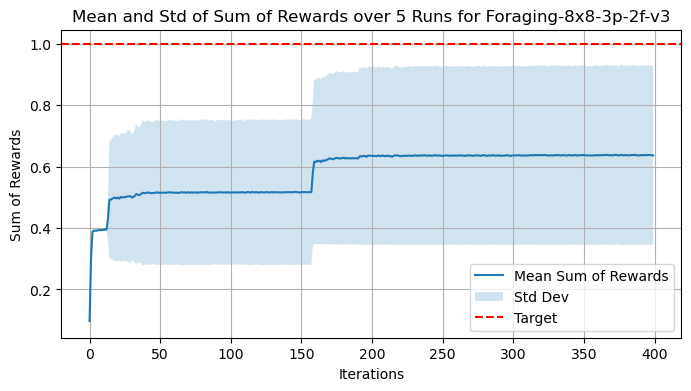

In [15]:
plot_sum_all_rewards(all_rewards, config)

In [17]:
run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0.0, 'agent_1': 0, 'agent_2': 0}